## Run Evaluation
## Introduction
This notebook is for evaluation of LaPSUM.

It expects the data to be loaded from the evaluation trial.

### Import Libraries


In [56]:
import os
import sys
sys.path.append(os.path.abspath("../"))

In [57]:
import re  # For regex-based extraction of scores and explanations
import pandas as pd
import random
import time

from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOllama
from groq import Groq
from groq import RateLimitError, APIError
from langchain.chains import LLMChain
from dotenv import load_dotenv


In [58]:
data = pd.concat([pd.read_csv(f"../data/generated/generated_{i}.csv") for i in range(9,15)], ignore_index=True)
len(data)

1020

In [59]:
data = data.sort_values(by=['question_id', 'project', 'run_id'])
data['response_label'] = data.groupby(['question_id', 'project']).cumcount() + 1
data['response_label'] = 'response_' + data['response_label'].astype(str)

# Step 2: Pivot final_response
response_pivot = data.pivot_table(
    index=['question_id', 'project'],
    columns='response_label',
    values='final_response',
    aggfunc='first'
)

# Step 3: Extract one question per (question_id, project)
question_lookup = data.drop_duplicates(subset=['question_id', 'project'])[['question_id', 'project', 'question']]

# Step 4: Merge the question back into the pivoted data
final_df = pd.merge(question_lookup, response_pivot.reset_index(), on=['question_id', 'project'])

# Optional: Reorder columns
cols = ['question_id', 'project', 'question'] + [col for col in final_df.columns if col.startswith('response_')]
final_df = final_df[cols]


In [60]:
final_df.to_csv("../data/generated/combined_reponse.csv", index=False)

In [61]:
final_df.head(5)

,question_id,project,question,response_1,response_2,response_3,response_4,response_5,response_6
0,1,groovy/groovy-core,Is there an entity named something like PojoCa...,"\n\nHowever, this information doesn't actually...","\n\nUnfortunately, the information provided do...","\n\nYes, there is an entity named `PojoCachedM...",[],"\n\nYes, there is an entity named `PojoCachedM...","\n\nYes, there is an entity named exactly `Poj..."
1,1,joestelmach/natty,Is there an entity named something like Parser...,Error: cound not answer,Error: cound not answer,Error: cound not answer,"\n\nYes, there is an entity named ""Parser"" in ...","\n\nYes, there is an entity named ""Parser"" in ...","\n\nSo yes, there is an entity named ""Parser"" ..."
2,1,pedrovgs/Renderers,Is there an entity named something like Recycl...,"\n\nHowever, this information doesn't clearly ...","\n\nYes, there is an entity named exactly ""Rec...","\n\nYes, there is an entity named RecyclerView...","\n\nYes, there is an entity named exactly ""Rec...","\n\nYes, there is an entity named exactly ""Rec...","\n\nYes, there is an entity named `RecyclerVie..."
3,1,sstrickx/yahoofinance-api,Is there an entity named something like YahooF...,"\n\nBased on the limited information provided,...","\n\nSo yes, there is an entity named YahooFina...","\n\nSo yes, there is an entity named YahooFina...","\n\nBased on the information provided, I don't...","\n\nYes, there is an entity named YahooFinance...",\n\nThis information is incomplete and doesn't...
4,1,wg/scrypt,Is there an entity named something like SCrypt...,"\n\nYes, there are several entities with names...","\n\nBased on the information provided, I don't...","\n\nI don't see any entity named ""SCrypt"" or a...","\n\nHowever, this information is quite limited...","\n\nHowever, none of these appears to be named...","\n\nBased on this information, there doesn't a..."


## Evaluation 

In [63]:
# Move the evaluation code here
load_dotenv()

df = pd.read_csv("../data/generated/combined_reponse.csv")

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

In [64]:
def send_to_groq(query, max_retries=5, initial_delay=60):
    retries = 0
    delay = initial_delay

    while retries < max_retries:
        try:
            # Send the query to the Groq chat model
            chat_completion = client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": query,
                    }
                ],
                model="llama3-70b-8192",
                temperature=0.5
            )

            # Successful response
            response_text = chat_completion.choices[0].message.content
            break

        except RateLimitError:
            print(f"Rate limit hit. Retrying in {delay} seconds...")
            time.sleep(delay)
            retries += 1
            delay *= 2  # Exponential backoff

        except APIError as e:
            print(f"API error: {e}")
            raise e  # re-raise for now unless you want to handle other types

    else:
        raise RuntimeError("Exceeded maximum retries due to rate limiting.")

    # Parse the response text (same as before)
    scores = []
    explanations = []
    response_num_pattern = re.compile(r"Response\s*(\d+)")
    score_pattern = re.compile(r"Score\s*-\s*(\d+)")
    explanation_pattern = re.compile(r"Explanation.\s*(.*)")

    current_score = None
    current_explanation = None

    for line in response_text.split("\n"):
        if score_match := score_pattern.search(line):
            current_score = int(score_match.group(1))
        if explanation_match := explanation_pattern.search(line):
            current_explanation = explanation_match.group(1).strip()
        if current_score is not None and current_explanation is not None:
            scores.append(current_score)
            explanations.append(current_explanation)
            current_score = None
            current_explanation = None

    return scores, explanations

In [65]:
def process_and_map_scores(df_randomized):
    # Prepare the query for evaluation
    query_base = """
        You are an experienced evaluator assessing responses from developers to technical questions.

        For each question, the responses from the developers have been provided. Evaluate how well each response answers the question on a scale of 1-10, where:
        - 1 means the response is completely irrelevant or fails to answer the question.
        - 10 means the response fully answers the question, providing a thorough, clear, and correct explanation.

        For each response:
        - Consider the relevance of the response to the question.
        - Consider the completeness of the answer. Does the response cover all parts of the question?
        - Consider the clarity of the response. Is it easy to understand and well-explained?

        Return your evaluation in the following format:
        Response X: Score - X Explanation: Explanation of why you gave this score.

        Example Response:
        Response 1: Score - 4 Explanation: While the response is relevant to the question it fails to provide contextual details.

        Here is the question and response:
    """

    evaluation_results = []  # To store the results (scores and explanations)

    # Iterate over each row in the randomized data to send each response individually
    for idx, row in df_randomized.iterrows():
        project = row['project']
        question = row['question']
        question_id = row['question_id']
        response = row['response']
        original_index = row['original_index']
        response_order = row['response_order']

        # Construct the query for this specific response
        query = query_base + f"\t{question}: {response}\n"
        query += "\t\t---\n\t\tPlease provide a score (1-10) and an explanation for this response."

        # Send the query to Ollama (or any other evaluator)
        ollama_scores, ollama_explanations = send_to_groq(query)  # Define this function to send and get responses

        # Store the score and explanation for this response
        evaluation_results.append({
            'project': project,
            'question': question,
            'question_id': question_id,
            'response': response,
            'original_index': original_index,
            'response_order': response_order,
            'score': ollama_scores[0],  # Assuming ollama_scores is a list of length 1 for each query
            'explanation': ollama_explanations[0]  # Assuming ollama_explanations is a list of length 1
        })

    # Convert the results to a DataFrame
    evaluation_df = pd.DataFrame(evaluation_results)

    # Sort the DataFrame by project, question_id, and response_order to get the correct final order
    evaluation_df = evaluation_df.sort_values(by=['project', 'question_id', 'response_order']).reset_index(drop=True)

    return evaluation_df

In [66]:
# Add original index column
df['original_index'] = df.index

# Step 1: Randomize order of projects
project_order = df['project'].unique().tolist()
random.shuffle(project_order)

# Step 2: Process and shuffle questions within each project
randomized_rows = []

for project in project_order:
    project_df = df[df['project'] == project].copy()

    # Shuffle questions within the project
    project_df = project_df.sample(frac=1).reset_index(drop=True)

    randomized_rows.append(project_df)

# Step 3: Combine all randomized rows
df_randomized = pd.concat(randomized_rows, ignore_index=True)

# Melt the response columns into individual rows
response_columns = [f"response_{i}" for i in range(1, 7)]
df_long = df_randomized.melt(
    id_vars=['project', 'question_id', 'question', 'original_index'],
    value_vars=response_columns,
    var_name='response_column',
    value_name='response'
)

# Drop any rows with missing responses
df_long = df_long.dropna(subset=['response'])

# Correcting the regular expression to avoid the warning
df_long['response_order'] = df_long['response_column'].str.extract(r'(\d+)').astype(int)

# Drop the helper column
df_long = df_long.drop(columns=['response_column'])

In [67]:
evaluation_df = process_and_map_scores(df_long)

In [68]:
# Display the results
# Create wide-format response, score, and explanation columns
df_wide = evaluation_df.pivot_table(
    index=['original_index', 'project', 'question_id', 'question'],
    columns='response_order',
    values=['response', 'score', 'explanation'],
    aggfunc='first'
)

# Flatten MultiIndex columns (e.g., ('response', 1) → response_1)
df_wide.columns = [f"{col[0]}_{col[1]}" for col in df_wide.columns]

# Reset index to make it a flat DataFrame again
df_wide = df_wide.reset_index()

# Optional: sort by original_index to restore CSV order
df_wide = df_wide.sort_values(by='original_index').reset_index(drop=True)

df_wide.to_csv("../data/generated/llama-3.3-70b-versatile.csv")

## Analysis 

In [71]:
data = pd.read_csv("../data/generated/llama-3.3-70b-versatile.csv")

In [103]:
data[['question_id','project','score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6']].head()

,question_id,project,score_1,score_2,score_3,score_4,score_5,score_6
0,1,groovy/groovy-core,7,2,8,1,8,10
1,1,joestelmach/natty,1,1,1,8,8,8
2,1,pedrovgs/Renderers,7,10,9,9,10,9
3,1,sstrickx/yahoofinance-api,6,9,8,7,9,2
4,1,wg/scrypt,9,8,8,8,8,8


### Descriptive Statistics

In [101]:
data[['score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6']].describe()

,score_1,score_2,score_3,score_4,score_5,score_6
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,3.494118,3.658824,3.570588,4.364706,4.794118,4.852941
std,3.149616,3.263762,3.178751,3.288305,3.315549,3.230150
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,4.000000,6.000000,6.000000
75%,7.000000,7.750000,7.000000,8.000000,8.000000,8.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


### Friedman Test (non-parametric, best for ordinal scores)

In [106]:
import itertools
from scipy.stats import friedmanchisquare, wilcoxon

In [110]:
score_columns = [f"score_{i}" for i in range(1, 7)]
friedman_stat, friedman_p = friedmanchisquare(*[data[col] for col in score_columns])
print(f"Friedman test: chi-square = {friedman_stat:.3f}, p = {friedman_p:.10f}")

Friedman test: chi-square = 48.176, p = 0.0000000033


#### There is a statistically significant difference between at least some of the agent configurations.

### Step 2: Pairwise Wilcoxon Tests

In [ ]:
results = []
pairs = list(itertools.combinations(score_columns, 2))

for a, b in pairs:
    stat, p = wilcoxon(data[a], data[b])
    results.append({
        "Config_A": a,
        "Config_B": b,
        "Statistic": stat,
        "p_value": p
    })

wilcoxon_df = pd.DataFrame(results)

# Optional: Bonferroni correction
bonferroni_threshold = 0.05 / len(wilcoxon_df)
wilcoxon_df["Bonferroni_Significant"] = wilcoxon_df["p_value"] < bonferroni_threshold

print("\nWilcoxon pairwise comparisons (with Bonferroni correction):")
print(wilcoxon_df)


Wilcoxon pairwise comparisons (with Bonferroni correction):
   Config_A Config_B  Statistic   p_value  Bonferroni_Significant
0   score_1  score_2     1320.0  0.457046                   False
1   score_1  score_3     1576.5  0.833789                   False
2   score_1  score_4     1755.0  0.007662                   False
3   score_1  score_5     1038.5  0.000010                    True
4   score_1  score_6     1090.0  0.000005                    True
5   score_2  score_3     1494.0  0.672888                   False
6   score_2  score_4     1962.5  0.036708                   False
7   score_2  score_5     1176.5  0.000412                    True
8   score_2  score_6     1493.0  0.000225                    True
9   score_3  score_4     1699.5  0.009730                   False
10  score_3  score_5     1255.5  0.000079                    True
11  score_3  score_6     1607.0  0.000063                    True
12  score_4  score_5     1857.5  0.154669                   False
13  score_4  sc

#### These six pairs show strong evidence that `score_5` and `score_6` are consistently better/worse than other configurations.

In [118]:
from scipy.stats import rankdata
# Step 1: Extract score columns
score_data = data[score_columns]

# Step 2: Rank each row (higher scores get lower rank number, e.g. best = 1)
ranked_data = score_data.apply(lambda row: rankdata(-row), axis=1)
ranked_data.shape

(170,)

In [119]:
from scipy.stats import rankdata
# Step 1: Rank each row (higher scores should get lower ranks, so use -row)
ranked_data = score_data.apply(lambda row: rankdata(-row), axis=1, result_type='expand')
ranked_data.columns = score_columns  # Rename columns to match original scores

# Step 2: Compute Kendall's W
rank_sums = ranked_data.sum(axis=0)
mean_rank_sum = rank_sums.mean()
m = ranked_data.shape[0]  # number of items ranked (rows/questions)
n = ranked_data.shape[1]  # number of raters (configs)

S = ((rank_sums - mean_rank_sum) ** 2).sum()
kendalls_W = (12 * S) / (m**2 * (n**3 - n))

print(f"Kendall's W: {kendalls_W:.3f}")

Kendall's W: 0.037


- Kendall’s W ranges from 0 (no agreement) to 1 (complete agreement).
- A value of 0.037 indicates low agreement in the relative ranking of configurations across different questions.
- This suggests that the best-performing configuration varies depending on the question.


### Let's analize per question category

In [120]:
## TODO

## Visualization

/var/folders/8_/8mh1m3v91fn2rsrmp3sgl4vm0000gn/T/ipykernel_45770/1874268657.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Configuration", y="Score", data=melted, palette="Set2")


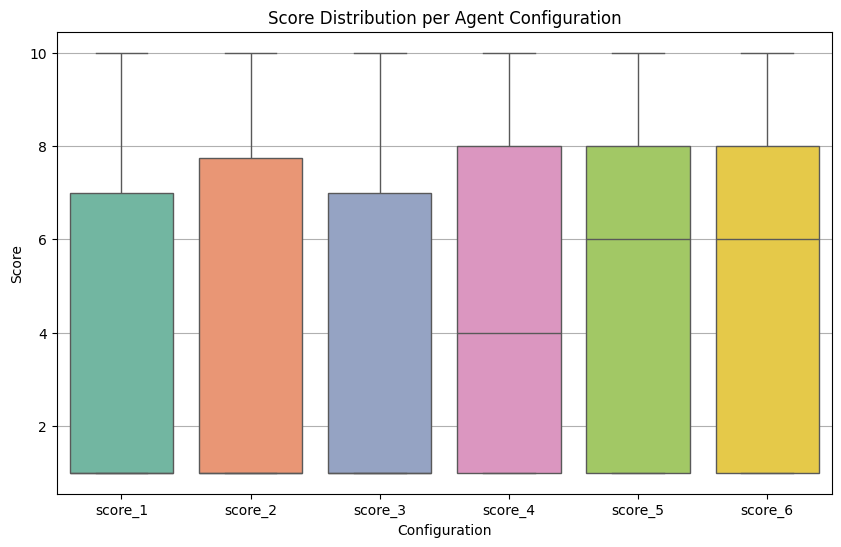

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame to long format for seaborn
melted = data.melt(id_vars=["question_id", "project"], value_vars=score_columns,
                 var_name="Configuration", value_name="Score")

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Configuration", y="Score", data=melted, palette="Set2")
plt.title("Score Distribution per Agent Configuration")
plt.grid(axis='y')
plt.show()

#### Boxplot: Score Distribution per Agent Configuration

📌 What it shows:
- Distribution of scores (1–10) for each agent configuration (`score_1` to `score_6`).
- Median (middle line), interquartile range (box), and outliers (points outside whiskers).

🧠 Insights:
- `score_5` and `score_6` have higher medians and more concentrated upper scores, suggesting better and more consistent responses.
- `score_1` and `score_3` show a wider spread with lower medians — likely underperforming configurations.
- This plot confirms that some configs regularly produce high-quality answers, while others vary more.

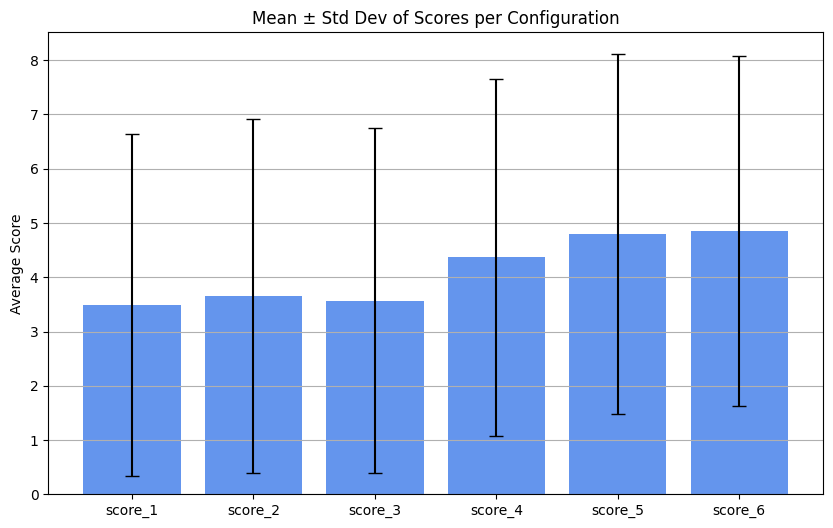

In [124]:
# Compute mean and std
desc_stats = melted.groupby("Configuration")["Score"].agg(["mean", "std"]).reset_index()

# Bar plot with error bars
plt.figure(figsize=(10, 6))
plt.bar(desc_stats["Configuration"], desc_stats["mean"], yerr=desc_stats["std"], capsize=5, color="cornflowerblue")
plt.ylabel("Average Score")
plt.title("Mean ± Std Dev of Scores per Configuration")
plt.grid(axis='y')
plt.show()

#### Barplot: Mean ± Std Dev of Scores

📌 What it shows:
- Average score for each configuration with error bars representing standard deviation.

🧠 Insights:
- `score_5` and `score_6` have the highest mean scores (~4.8), outperforming others on average.
- Their large standard deviations show that while they score high, they still vary significantly — likely depending on the question type.
- `score_1` to `score_3` have lower means (~3.5) and similar variability.

This suggests `score_5` and `score_6` are generally better, but not universally superior.

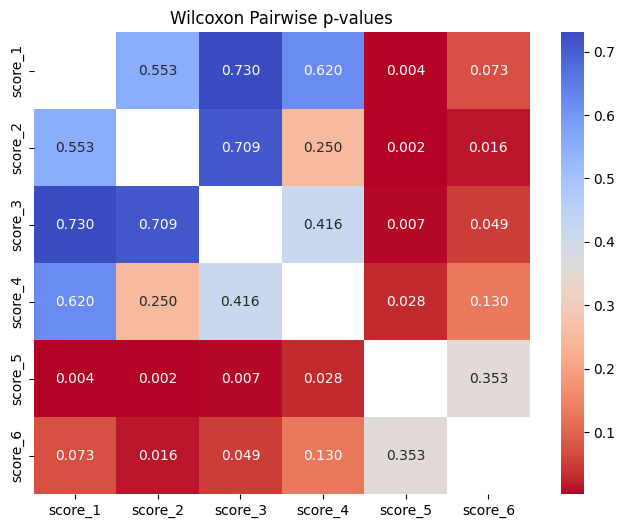

In [125]:
import numpy as np

# Create pivot matrix for heatmap
configs = sorted(set(wilcoxon_df["Config_A"]).union(wilcoxon_df["Config_B"]))
p_matrix = pd.DataFrame(np.nan, index=configs, columns=configs)

for _, row in wilcoxon_df.iterrows():
    a, b = row["Config_A"], row["Config_B"]
    p = row["p_value"]
    p_matrix.loc[a, b] = p
    p_matrix.loc[b, a] = p  # symmetric

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(p_matrix.astype(float), annot=True, fmt=".3f", cmap="coolwarm_r", mask=np.triu(p_matrix.isnull()))
plt.title("Wilcoxon Pairwise p-values")
plt.show()

#### Heatmap: Wilcoxon Pairwise p-values

📌 What it shows:
- Pairwise statistical comparison between configurations using the Wilcoxon signed-rank test.
- Lower values (red) = greater difference; p-values < 0.05 indicate significant difference.

🧠 Insights:
- `score_5` and `score_6` are significantly different from most other configurations:
- `score_5` vs `score_1` → $p = 0.004$
- `score_6` vs `score_2` → $p = 0.016$
- `score_1`, `score_2`, `score_3` have high p-values between them → little difference.
- Some borderline p-values (e.g., `score_6` vs `score_3` = 0.049) may or may not be significant depending on correction method used.

The heatmap statistically confirms what the boxplots suggest: `score_5` and `score_6` are the top performers, while `score_1` to `score_3` are largely indistinguishable in effectiveness.

✅ Overall Takeaway:

Rank	Configuration	Comment
🥇	score_6	High mean, good spread, significant difference vs others
🥈	score_5	Same as above, slightly lower or comparable
🥉	score_4	Moderate performance
—	score_1–3	Lower scores, not significantly different

Recommendation: Focus future agent iterations on improving or combining the strategies behind score_5 and score_6. You may also drop or refactor underperforming ones (e.g., score_1).

Would you like help annotating the plots or generating a LaTeX-ready summary of these findings?